# Spatial Stochastic Simulation with SpatialPy

## Definition of the model

Here we illustrate how to implement the model describet in [Sturrock M, Hellander A, Matzavinos A, Chaplain MAJ. 2013 Spatial stochastic modelling of the Hes1 gene regulatory network: intrinsic noise can explain heterogeneity in embryonic stem cell differentiation. J R Soc Interface 10:20120988]

You may need to install specific version to get this notebook to work:

python3 -m pip install meshio==2.3.10

python3 -m pip install pygmsh==5.0.2

### Imports and definitions

In [1]:
import os
import sys
sys.path.insert(1, "../..")
import numpy
import matplotlib.pyplot as plt

import spatialpy

In [2]:
class Nucleus(spatialpy.Geometry):
    def inside(self, x, on_boundary):
        return x[0]**2 + x[1]**2 + x[2]**2 <= 3**2

In [3]:
class Cytoplasm(spatialpy.Geometry):
    def inside(self, x, on_boundary):
        return x[0]**2 + x[1]**2 + x[2]**2 > 3**2

### Model

In [4]:
class hes1(spatialpy.Model):
    def __init__(self, model_name="hes1"):
        spatialpy.Model.__init__(self, model_name)

        #Domain
        domain = spatialpy.Domain.read_xml_mesh("mesh/GRN_Spatial.mesh.xml")
        #Types
        domain.read_stochss_subdomain_file("mesh/GRN_Spatial.subdomains.txt")
        self.add_domain(domain)

        cytoplasm=2
        #self.set_type(Cytoplasm(), cytoplasm)
        #self.set_type(Nucleus(), 2)
        # promoter site
        #self.domain.type[self.domain.closest_vertex([0]*3)] = 3

        #Parameters
        #mu = 2e-3
        #kappa=0.015
        #ka = 1e7
        #kd = 0.01
        #gamma_m = 6e-4 
        #gamma_p = gamma_m/2.0 
        #NA = 6.022e23
        D_P=1e-12
        D_mRNA=1e-12
        
        mu = spatialpy.Parameter(name='mu', expression=0.002)
        kappa = spatialpy.Parameter(name='kappa', expression=0.015)
        #ka = spatialpy.Parameter(name='ka', expression=ka/(1000*NA))
        ka = spatialpy.Parameter(name='ka', expression=1.6605778811e-20)
        
        kd = spatialpy.Parameter(name='kd', expression=0.01)
        gamma_m = spatialpy.Parameter(name='gamma_m', expression=6e-4)
        gamma_p = spatialpy.Parameter(name='gamma_p', expression=3e-4)
        self.add_parameter([mu,kappa,ka,kd,gamma_m,gamma_p])

        # Species
        G_f = spatialpy.Species(name='G_f', diffusion_coefficient=0.0)
        G_o = spatialpy.Species(name='G_o', diffusion_coefficient=0.0)
        mRNA = spatialpy.Species(name='mRNA',diffusion_coefficient=D_mRNA)
        P = spatialpy.Species(name='P', diffusion_coefficient=D_P)
        self.add_species([G_f,G_o,mRNA,P])

         # Reactions
        rxn1 = spatialpy.Reaction(name = 'R1',reactants={G_f:1,P:1}, products = {G_o:1}, rate=ka)
        rxn2 = spatialpy.Reaction(name = 'R2',reactants={mRNA:1}, products = {mRNA:1,P:1}, rate=kappa,restrict_to=cytoplasm)
        rxn3 = spatialpy.Reaction(name = 'R3',reactants={G_f:1}, products = {G_f:1,mRNA:1},rate=mu)
        rxn4 = spatialpy.Reaction(name = 'R4',reactants={mRNA:1}, products = {}, rate=gamma_m)
        rxn5 = spatialpy.Reaction(name = 'R5',reactants={P:1}, products = {}, rate=gamma_p)
        rxn6 = spatialpy.Reaction(name = 'R6',reactants={G_o:1}, products = {G_f:1,P:1}, rate=kd)

        self.add_reaction([rxn1,rxn2,rxn3,rxn4,rxn5,rxn6])
        
        #Initail Conditions
        self.add_initial_condition(spatialpy.PlaceInitialCondition(G_f, 1, location=[0,0,0]))
        
        self.timespan(numpy.linspace(0,24*3600,2000) , timestep_size=1)

In [5]:
model = hes1()

## Running the model and processing the results

In [6]:
from spatialpy import Solver
sol = Solver(model, debug_level=0)
%time sol.compile()
print(sol.build_dir)

CPU times: user 570 ms, sys: 0 ns, total: 570 ms
Wall time: 2.8 s
/tmp/spatialpy_build_fzf02ypq


In [7]:
#%time result = model.run(debug_level=0)
%time result = sol.run()

CPU times: user 49.8 ms, sys: 6.65 ms, total: 56.5 ms
Wall time: 30min 37s


### Plot the evolution of the copy number of a given species

In [14]:
def plot_hes1(result):
    protein = result.get_species("P")
    proteinsum = numpy.sum(protein,axis=1)
    plt.plot(numpy.array(result.tspan)/3600,proteinsum,'r', label='protein')
    mRNA = result.get_species("mRNA")
    mRNAsum=numpy.sum(mRNA[:],axis=1)
    plt.plot(numpy.array(result.tspan)/3600,mRNAsum,'b', label='mRNA')
    plt.legend(loc='best')
    plt.xlabel('time (h)')
    plt.ylabel('# of molecules')

CPU times: user 38.4 s, sys: 872 ms, total: 39.3 s
Wall time: 39.4 s


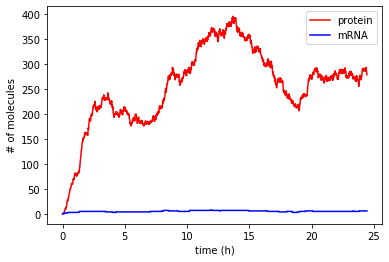

In [15]:
%time plot_hes1(result)

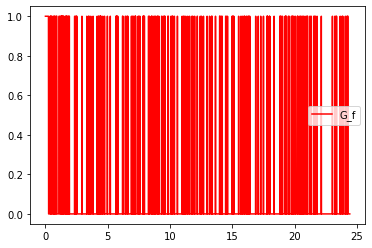

In [16]:
pf = numpy.sum(result.get_species("G_f"),axis=1)
#po = numpy.sum(result.get_species("G_o"),axis=1)
plt.plot(numpy.array(result.tspan)/3600,pf,'r',label="G_f")
#plt.plot(result.tspan,po,'b',label="G_o")
plt.legend(loc="best")